# 단순 선형 회귀 (학습성능개선)

텐서플로우의 학습성능을 개선하기 위해 아래의 기능을 사용할 수 있음

1. 데이터 표준화: 학습률 향상에 도움을 줌
2. 콜백함수: 모델의 학습 방향, 저장 시점, 학습 정지 시점 등에 관한 상황을 모니터링 하기 위한 도구

## 데이터 정규화(Normalization, 표준화)

### 1) 데이터 정규화의 이해

#### 데이터 정규화란?

모든 데이터가 동일한 정도의 스케일(중요도)로 반영되도록 해 주는 처리

#### 정규화를 해야 하는 이유

머신러닝 알고리즘은 데이터가 가진 feature(특성)들을 비교하여 데이터의 패턴을 찾는다.

이 때, 데이터가 가진 feature의 스케일이 심하게 차이가 나는 경우 수많은 학습 단계를 거쳐서 최적값에 도달하게 된다.

데이터에 정규화 처리를 적용하면 쉽게 최적값에 도달할 수 있으며 학습률을 상대적으로 높여서 사용할 수 있기 때문에 빠르게 훈련시킬 수 있다.

### 2) 데이터 정규화 방법

#### 최소-최대 정규화 (Min-Max Normalization)

모든 feature에 대해 각각의 최소값 0, 최대값 1로, 그리고 다른 값들은 0과 1 사이의 값으로 변환.

예를 들어 어떤 특성의 최소값이 20이고 최대값이 40인 경우, 30이라는 데이터가 있을 경우,
20은 `0`, 40은 `1`로 환산되기 때문에 30은 중간치인 `0.5`로 변환됨.

## 콜백함수

모델의 학습 방향, 저장 시점, 학습 정지 시점 등에 관한 상황을 모니터링하기 위한 도구

### 콜백함수 사용 방법

#### 콜백 정의

```pyhon
callbacks = [  콜백1, 콜백2, ... 콜백n  ]
```

#### 학습을 위한 fit() 함수에서 callbacks 파라미터에 미리 정의한 리스트를 지정

```python
callbacks = [콜백1, 콜백2, ... , 콜백n]
model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 500, callbacks = callbacks)
```

혹은

```python
model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 500, callbacks = [
    콜백1, 콜백2, ... , 콜백n
])
```

### 콜백함수 종류

#### 1) `EarlyStopping()`

모델 학습 시에 지정된 기간 동안 모니터링하는 평가지표에서 더 이상 성능 향상이 일어나지 않은 경우 학습을 스스로 중단

```python
EarlyStopping(monitor='평가지표', patience=10, verbose=1)
```

- patience: 지정한 수만큼의 기간에서 평가지표의 향상이 일어나지 않을 경우 학습을 중단 (기간이라 함은 에폭을 의미)
예를 들어 patience=`10`일 때, `10`에폭 동안 성능 향상이 일어나지 않으면 학습을 중단. 즉, 10회 이상 성능향상이 발견되지 않으면 중단함
- verbose: 콜백의 수행 과정 노출 여부를 지정.
    * 0: 아무런 표시 하지 않음(기본값)
    * 1: 프로그래스바로 표시
    * 2: 매 에폭마다 수행과정을 자세하게 출력함.

#### 2) `ReduceLROnPlateau()`

EarlyStopping 콜백과 같이 patience 인자를 지정하여, 지정된 기간 동안 평가지표에서 성능 향상이 일어나지 않으면 학습률을 조정하는 콜백

```python
ReduceLROnPlateau(monitor='평가지표', factor=0.1, patience=10, min_lr=0, verbose=1)
```

- factor: 학습률 조정에 사용되는 값 (새로운 학습률 = factor * 기존 학습률)
- patience: 지정한 수만큼의 기간에서 성능 향상이 일어나지 않을 경우, 학습률을 조정
- min_lr: 학습률의 하한을 지정
- verbose: 콜백의 수행 과정 노출 여부를 지정.

#### 3) `ModelCheckpoint()`

지정한 평가지표를 기준으로 가장 뛰어난 성능을 보여주는 모델을 저장 할 때 사용

```python
ModelCheckpoint(filepath, monitor='평가지표', verbose=1, save_best_only=True|False, save_weights_only=False)
```

- filepath: 모델의 저장 경로를 지정
- save_best_only: True인 경우, 가장 성능이 뛰어난 모델만 저장. 그보다 좋지 않은 모델의 경우는 덮어쓰지 않는다.
- save_weights_only: 모델의 가중치만 저장

## #01. 패키지 준비하기

In [52]:
import sys, os
sys.path.append('../../')
import helper

from pandas import read_excel, DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

# 데이터를 훈련용과 테스트용으로 나누는 기능
from sklearn.model_selection import train_test_split

# 모델을 구성하기위한 객체
from tensorflow.keras.models import Sequential
# 모델에 학습층을 쌓기 위한 클래스
from tensorflow.keras.layers import Dense


#-------- 추가 패키지 --------#
# 데이터 정규화를 위한 패키지 참조
from sklearn.preprocessing import MinMaxScaler

# 학습에 대한 콜백함수 참조
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

## #02. 데이터셋 준비하기

In [75]:
origin = read_excel('https://data.hossam.kr/E04/cars.xlsx')
origin

,speed,dist
0,4,2
1,4,10
2,7,4
3,7,22
4,8,16
5,9,10
6,10,18
7,10,26
8,10,34
9,11,17


## #03. 데이터 전처리

### 결측치 확인

In [54]:
origin.isna().sum()

speed    0
dist     0
dtype: int64

> 결측치 없음

## #04. 탐색적 데이터 분석

### 기본통계 확인

In [55]:
origin.describe()

,speed,dist
count,50.000000,50.000000
mean,15.400000,42.980000
std,5.287644,25.769377
min,4.000000,2.000000
25%,12.000000,26.000000
50%,15.000000,36.000000
75%,19.000000,56.000000
max,25.000000,120.000000


### 산점도 그래프와 추세선 확인

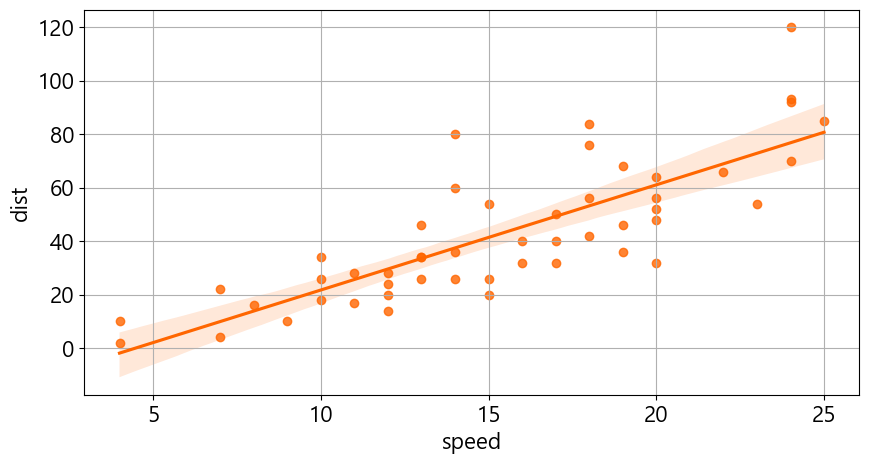

In [56]:
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10, 5))
sb.regplot(data=origin, x='speed', y='dist', color='#ff6600')
plt.grid()

plt.show()
plt.close()

> 곡선보다는 선형 분포에 더 가까우므로 단순선형회귀모델을 적용하기로 함

> 데이터의 범위는 `0~1` 사이로 변화했지만 전체적인 상관관계는 변하지 않았음을 알 수 있다.

## #05. 데이터셋 분할하기

### 1. 랜덤시드 고정

In [57]:
np.random.seed(777)

### 2. 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기

In [58]:
x = origin.drop(['dist'], axis=1)
y = origin[['dist']]
print("훈련데이터 크기:", x.shape, "/ 레이블 크기:", y.shape)

훈련데이터 크기: (50, 1) / 레이블 크기: (50, 1)


### (추가) 데이터 정규화(표준화) 수행

독립변수 표준화

In [59]:
x_scaler = MinMaxScaler()
x_scale = x_scaler.fit_transform(x)
x_scale

array([[0.        ],
       [0.        ],
       [0.14285714],
       [0.14285714],
       [0.19047619],
       [0.23809524],
       [0.28571429],
       [0.28571429],
       [0.28571429],
       [0.33333333],
       [0.33333333],
       [0.38095238],
       [0.38095238],
       [0.38095238],
       [0.38095238],
       [0.42857143],
       [0.42857143],
       [0.42857143],
       [0.42857143],
       [0.47619048],
       [0.47619048],
       [0.47619048],
       [0.47619048],
       [0.52380952],
       [0.52380952],
       [0.52380952],
       [0.57142857],
       [0.57142857],
       [0.61904762],
       [0.61904762],
       [0.61904762],
       [0.66666667],
       [0.66666667],
       [0.66666667],
       [0.66666667],
       [0.71428571],
       [0.71428571],
       [0.71428571],
       [0.76190476],
       [0.76190476],
       [0.76190476],
       [0.76190476],
       [0.76190476],
       [0.85714286],
       [0.9047619 ],
       [0.95238095],
       [0.95238095],
       [0.952

종속변수 표준화

In [60]:
y_scaler = MinMaxScaler()
y_scale = y_scaler.fit_transform(y)
y_scale

array([[0.        ],
       [0.06779661],
       [0.01694915],
       [0.16949153],
       [0.11864407],
       [0.06779661],
       [0.13559322],
       [0.20338983],
       [0.27118644],
       [0.12711864],
       [0.22033898],
       [0.10169492],
       [0.15254237],
       [0.18644068],
       [0.22033898],
       [0.20338983],
       [0.27118644],
       [0.27118644],
       [0.37288136],
       [0.20338983],
       [0.28813559],
       [0.49152542],
       [0.66101695],
       [0.15254237],
       [0.20338983],
       [0.44067797],
       [0.25423729],
       [0.3220339 ],
       [0.25423729],
       [0.3220339 ],
       [0.40677966],
       [0.33898305],
       [0.45762712],
       [0.62711864],
       [0.69491525],
       [0.28813559],
       [0.37288136],
       [0.55932203],
       [0.25423729],
       [0.38983051],
       [0.42372881],
       [0.45762712],
       [0.52542373],
       [0.54237288],
       [0.44067797],
       [0.57627119],
       [0.76271186],
       [0.771

### 3. 훈련데이터와 검증 데이터로 분할

In [61]:
x_train, x_test, y_train, y_test = train_test_split(x_scale, y_scale, test_size=0.3, random_state=42)
print("훈련용 데이터셋 크기: %d, 검증용 데이터셋 크기: %d" % (len(x_train), len(x_test)))

훈련용 데이터셋 크기: 35, 검증용 데이터셋 크기: 15


## #06. 모델 개발

### 1. 모델 정의

In [62]:
model = Sequential()
# 1차원의 데이터를 입력으로 받고, 32개의 출력을 가지는 첫 번째 Dense 층
model.add(Dense(32, activation = 'relu', input_shape = (1, )))
# 하나의 값을 출력
# -> 정답의 범위가 정해지지 않기 때문에 활성화 함수는 linear
# -> linear는 기본값이므로 생략 가능함.
model.add(Dense(1, activation='linear'))

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                64        
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 97 (388.00 Byte)
Trainable params: 97 (388.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [73]:
os.getcwd()

'd:\\jihun5\\jupyter\\05-데이터마이닝\\03_tensorflow'

### (수정) 학습하기

In [74]:
#result = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test))
# 파일이 저장될 경로(폴더) 지정 (한글,공백,점(.)이 포함되어 있을 경우 에러 발생함)
checkpoint_path = os.path.join("D:\\tensorflow_checkpoint\\model07-cp-{epoch:04d}-ckpt")

result = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test), callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1),
    ModelCheckpoint(filepath = 'reg_check_point.h5', monitor = 'val_loss', verbose=1, save_best_only = True)
])

# 학습결과
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)
result_df

Epoch 1/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0218 - mae: 0.1239


Epoch 1: val_loss improved from inf to 0.02150, saving model to reg_check_point.h5
2/2 [==============================] - 0s 77ms/step - loss: 0.0208 - mae: 0.1210 - val_loss: 0.0215 - val_mae: 0.1005 - lr: 1.2500e-04
Epoch 2/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0179 - mae: 0.1117
Epoch 2: val_loss did not improve from 0.02150
2/2 [==============================] - 0s 31ms/step - loss: 0.0208 - mae: 0.1209 - val_loss: 0.0215 - val_mae: 0.1004 - lr: 1.2500e-04
Epoch 3/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0221 - mae: 0.1247
Epoch 3: val_loss did not improve from 0.02150
2/2 [==============================] - 0s 31ms/step - loss: 0.0208 - mae: 0.1209 - val_loss: 0.0215 - val_mae: 0.1004 - lr: 1.2500e-04
Epoch 4/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0164 - mae: 0.1084
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001.

Epoch 4: val_loss did not improve from 0.02150
2/2 [==============================] - 0s 26

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 60ms/step - loss: 0.0207 - mae: 0.1208 - val_loss: 0.0215 - val_mae: 0.1004 - lr: 1.0000e-04
Epoch 7/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0220 - mae: 0.1256
Epoch 7: val_loss improved from 0.02149 to 0.02149, saving model to reg_check_point.h5
2/2 [==============================] - 0s 45ms/step - loss: 0.0207 - mae: 0.1208 - val_loss: 0.0215 - val_mae: 0.1004 - lr: 1.0000e-04
Epoch 8/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0208 - mae: 0.1212
Epoch 8: val_loss improved from 0.02149 to 0.02148, saving model to reg_check_point.h5
2/2 [==============================] - 0s 46ms/step - loss: 0.0207 - mae: 0.1207 - val_loss: 0.0215 - val_mae: 0.1003 - lr: 1.0000e-04
Epoch 9/500
1/2 [==============>...............] - ETA: 0s - loss: 0.0223 - mae: 0.1267
Epoch 9: val_loss improved from 0.02148 to 0.02148, saving model to reg_check_point.h5
2/2 [==============================] - 0s 46ms/step - loss: 0.0207 - m

,loss,mae,val_loss,val_mae,lr
epochs,,,,,
1,0.020773,0.121034,0.021497,0.100454,0.000125
2,0.020772,0.120948,0.021503,0.100445,0.000125
3,0.020760,0.120856,0.021503,0.100429,0.000125
4,0.020757,0.120809,0.021500,0.100412,0.000125
5,0.020749,0.120774,0.021493,0.100394,0.000100
...,...,...,...,...,...
124,0.020159,0.118634,0.020663,0.097706,0.000100
125,0.020150,0.118513,0.020667,0.097684,0.000100
126,0.020139,0.118414,0.020669,0.097662,0.000100


## 7) 학습 결과 평가

### 1. 학습 결과 시각화

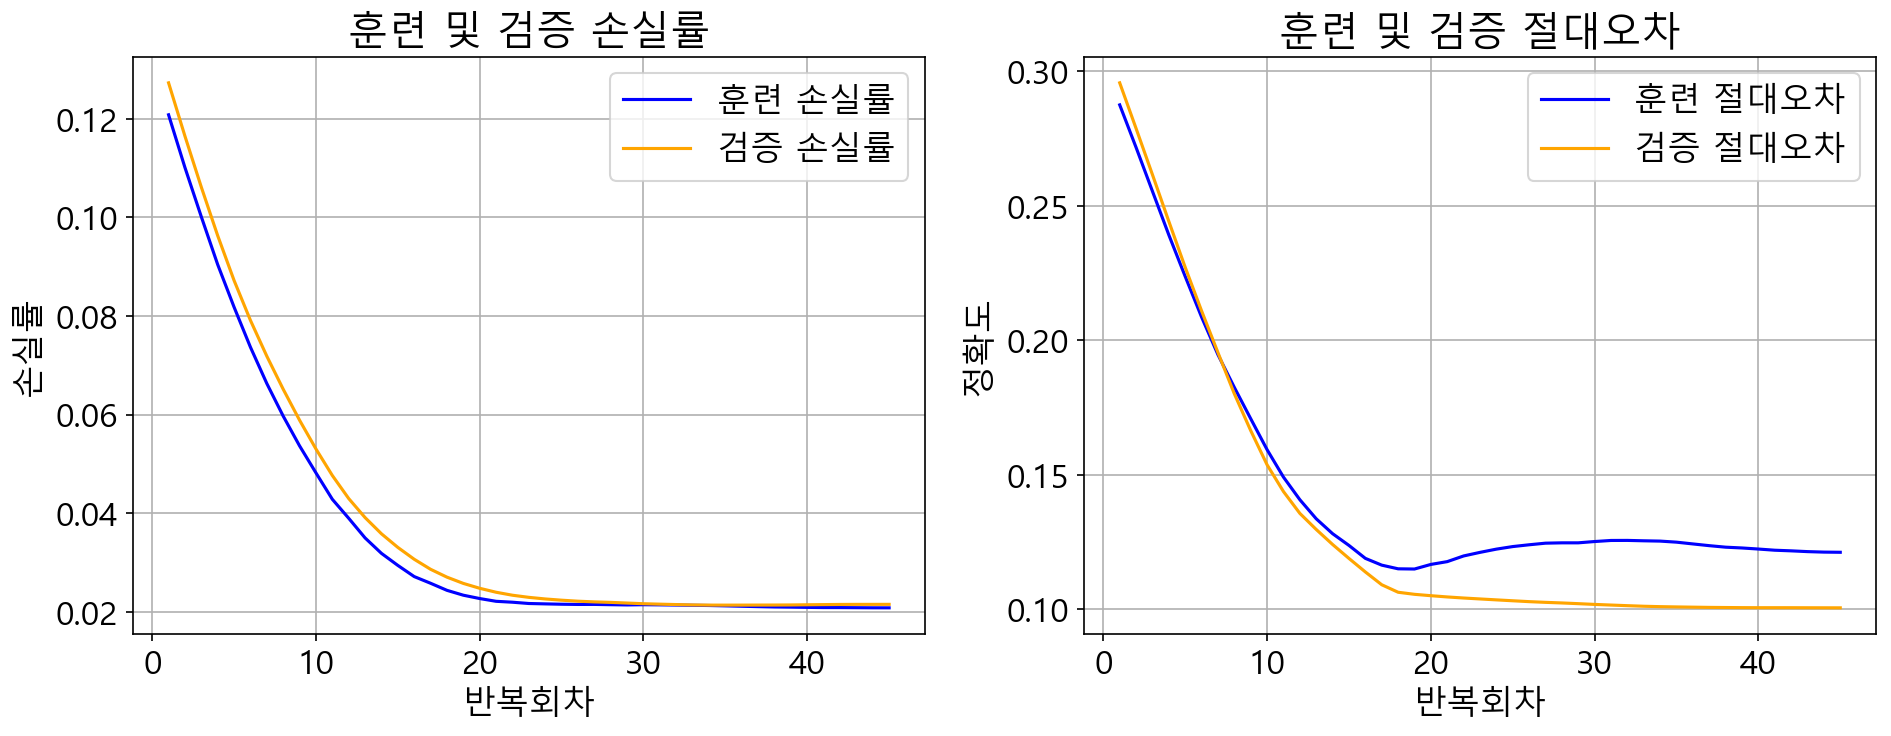

In [64]:
# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
# ----------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
# ----------------------------------------
sb.lineplot(x=result_df.index, y='loss', data=result_df, color='blue', label='훈련 손실률', ax=ax1)
sb.lineplot(x=result_df.index, y='val_loss', data=result_df, color='orange', label='검증 손실률', ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()

# 2) 훈련 및 검증 절대오차 그리기
# ----------------------------------------
sb.lineplot(x=result_df.index, y='mae', data=result_df, color = 'blue', label = '훈련 절대오차', ax=ax2)
sb.lineplot(x=result_df.index, y='val_mae', data=result_df, color = 'orange', label = '검증 절대오차', ax=ax2)
ax2.set_title('훈련 및 검증 절대오차')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

> ephocs를 500으로 지정했지만 50회 전에 학습을 멈춘 것을 확인할 수 있다. 즉, 학습을 조기 종료함으로서 학습 성능을 향상시켰다고 할 수 있다.

### 2. 모델 성능 평가

In [65]:
evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 절대오차: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 절대오차: %f" % (evaluate2[0], evaluate2[1]))

2/2 [==============================] - 0s 3ms/step - loss: 0.0208 - mae: 0.1210
최종 훈련 손실률: 0.020775, 최종 훈련 절대오차: 0.121046
1/1 [==============================] - 0s 19ms/step - loss: 0.0215 - mae: 0.1005
최종 검증 손실률: 0.021486, 최종 검증 절대오차: 0.100461


## #08. 학습 결과 적용

### 1. 테스트 데이터에 대한 예측 결과 산정

In [66]:
results = model.predict(x_test)
print(results)

1/1 [==============================] - 0s 38ms/step
[[0.29032212]
 [0.4507217 ]
 [0.39057186]
 [0.53092146]
 [0.31037205]
 [0.53092146]
 [0.3705219 ]
 [0.35047194]
 [0.4106218 ]
 [0.33042198]
 [0.29032212]
 [0.20587802]
 [0.43067175]
 [0.2482555 ]
 [0.18468928]]


### 2. 결과 데이터 셋 구성

In [67]:
kdf = DataFrame({
    '검증데이터': x_test.flatten(),
    '실제값': y_test.flatten(),
    '예측값' : results.flatten()
})

kdf['예측오차'] = kdf['실제값']-kdf['예측값']

kdf

,검증데이터,실제값,예측값,예측오차
0,0.380952,0.186441,0.290322,-0.103881
1,0.761905,0.389831,0.450722,-0.060891
2,0.619048,0.406780,0.390572,0.016208
3,0.952381,0.576271,0.530921,0.045350
4,0.428571,0.271186,0.310372,-0.039186
5,0.952381,1.000000,0.530921,0.469079
6,0.571429,0.254237,0.370522,-0.116285
7,0.523810,0.440678,0.350472,0.090206
8,0.666667,0.457627,0.410622,0.047005
9,0.476190,0.203390,0.330422,-0.127032


### 3. 실제 결과값과 머신러닝에 의한 예측값 비교

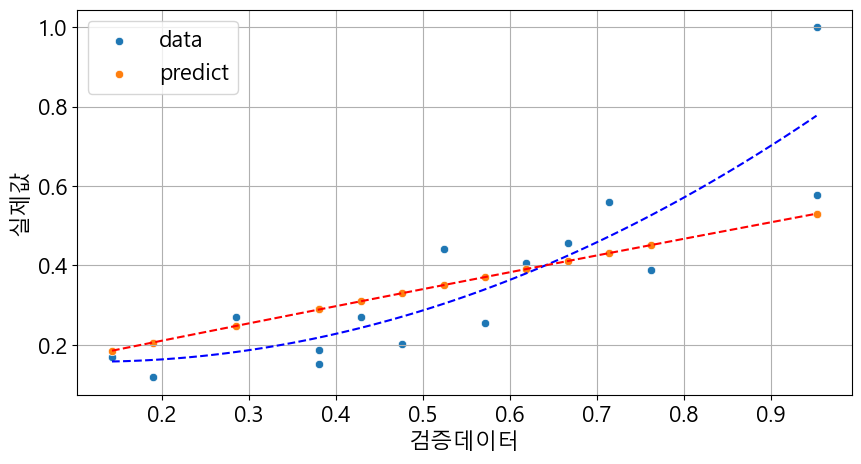

In [68]:
helper.regplot(x_left=kdf['검증데이터'], y_left=kdf['실제값'], y_left_pred=kdf['예측값'])

### 3. 임의의 값에 대한 머신러닝 예측 결과

In [69]:
# 속도가 50일 때의 제동거리를 예측해보자.
my_speed = 50

In [70]:
# 독립변수 표준화에 사용한 객체를 활용
my_speed_scale = x_scaler.transform([[my_speed]])
my_speed_scale

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([[2.19047619]])

In [71]:
results = model.predict(my_speed_scale)
results

1/1 [==============================] - 0s 19ms/step


array([[1.0163682]], dtype=float32)

In [72]:
# 예측 결과는 표준화된 값으로 나오기 때문에 원래의 단위로 되돌리기 위해 역변환
y_scaler.inverse_transform(results)

array([[121.93144]], dtype=float32)

#### 독립 변수와 종속 변수를 각각 표준화하기:

##### 독립 변수와 종속 변수를 따로따로 표준화하는 경우, 독립 변수와 종속 변수 각각의 특성을 독립적으로 고려합니다. 독립 변수의 표준화는 변수의 스케일을 조정하여 모델의 수렴 속도를 향상시키고 모델의 안정성을 높입니다. 종속 변수의 표준화는 종속 변수의 스케일을 조정하여 모델의 예측값을 더 좋게 만들기 위해 사용될 수 있습니다. 한 번에 독립 변수와 종속 변수를 표준화하기:

##### 종속 변수와 독립 변수를 동시에 표준화하는 경우, 두 변수 간의 상관 관계를 유지하며 스케일을 조정합니다. 이 방법은 종속 변수와 독립 변수 간의 스케일 불일치로 인한 문제를 방지할 수 있습니다. 특히 일부 머신러닝 모델 (예: 서포트 벡터 머신)에서 유용할 수 있습니다.